## Multilabel Classification of Research Articles 

Dataset Source: https://www.kaggle.com/datasets/shivanandmn/multilabel-classification-dataset

##### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

import transformers
from transformers import DataCollatorForSeq2Seq, AutoTokenizer, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import torch

##### Display Version of Relevant Libraries

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("NumPy:".rjust(15), np.__version__)
print("Torch:".rjust(15), transformers.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.7 
        Pandas: 1.4.4
         NumPy: 1.23.3
         Torch: 4.21.3
  Transformers: 4.21.3
      Datasets: 2.4.0
      Evaluate: 0.2.2


##### Ingest Data & Drop Unnecessary Feature

In [3]:
df = pd.read_csv("/Users/leedunn/Desktop/Projects to Train/multilabel_clf/train.csv")

df.drop(columns=['ID'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TITLE                 20972 non-null  object
 1   ABSTRACT              20972 non-null  object
 2   Computer Science      20972 non-null  int64 
 3   Physics               20972 non-null  int64 
 4   Mathematics           20972 non-null  int64 
 5   Statistics            20972 non-null  int64 
 6   Quantitative Biology  20972 non-null  int64 
 7   Quantitative Finance  20972 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.3+ MB


##### Data Preprocessing

In [4]:
df['text'] = df["TITLE"] + " : " + df["ABSTRACT"]

df.drop(columns=["TITLE", "ABSTRACT"], inplace=True)

df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps : ...
1,1,0,0,0,0,0,Rotation Invariance Neural Network : Rotatio...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,0,0,1,0,0,0,A finite element approximation for the stochas...
4,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


##### Visual: Histogram of Article Abstract's Word Lengths

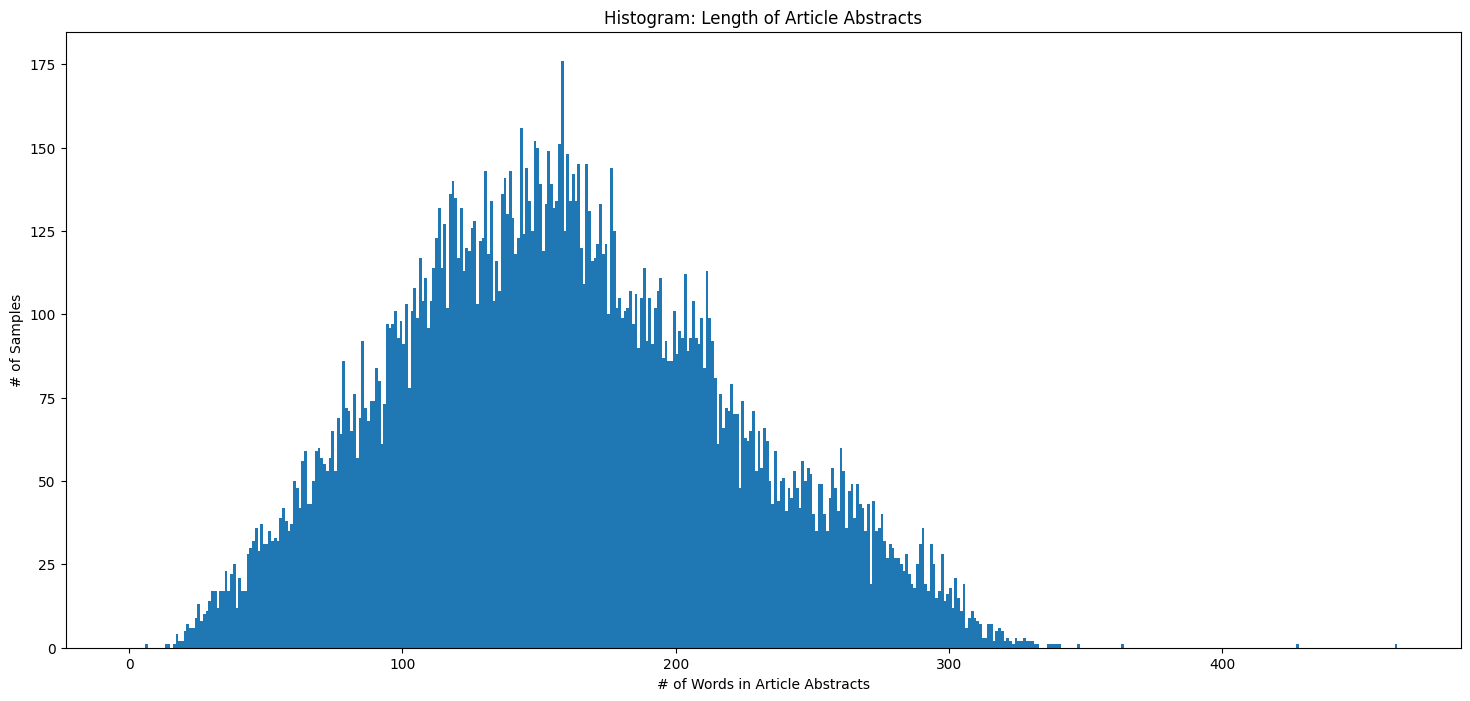

The maximum length of Article Abstracts (in words) is 463 words.


In [5]:
df['text_length'] = df['text'].str.split().str.len()

n_bin=464
df.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Article Abstracts')
plt.xlabel('# of Words in Article Abstracts')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Article Abstracts (in words) is {max(df['text_length'])} words.")

##### Data Preprocessing

In [6]:
upper_limit=350

# This only removes 3 samples (out of nearly 21,000 total samples)
df = df[df['text_length'] < (upper_limit + 1)]

df.drop(columns=["text_length", "Quantitative Finance"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20969 entries, 0 to 20971
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Computer Science      20969 non-null  int64 
 1   Physics               20969 non-null  int64 
 2   Mathematics           20969 non-null  int64 
 3   Statistics            20969 non-null  int64 
 4   Quantitative Biology  20969 non-null  int64 
 5   text                  20969 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


##### Create List of Labels & Dictionaries for Converting Between Strings & Integers

In [7]:
# label values & conversion dictionaries

labels = [x for x in df.columns if x not in ['text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

##### Convert Pandas DataFrame to Datasets & Split Dataset into Training/Testing/Evaluation Datasets

In [8]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][25]

Training Dataset Shape: (16775, 7)
Testing Dataset Shape: (2097, 7)
Evaluation Dataset Shape: (2097, 7)


{'Computer Science': 1,
 'Physics': 0,
 'Mathematics': 0,
 'Statistics': 0,
 'Quantitative Biology': 0,
 'text': "FBG-Based Position Estimation of Highly Deformable Continuum Manipulators: Model-Dependent vs. Data-Driven Approaches :   Conventional shape sensing techniques using Fiber Bragg Grating (FBG) involve\nfinding the curvature at discrete FBG active areas and integrating curvature\nover the length of the continuum dexterous manipulator (CDM) for tip position\nestimation (TPE). However, due to limited number of sensing locations and many\ngeometrical assumptions, these methods are prone to large error propagation\nespecially when the CDM undergoes large deflections. In this paper, we study\nthe complications of using the conventional TPE methods that are dependent on\nsensor model and propose a new data-driven method that overcomes these\nchallenges. The proposed method consists of a regression model that takes FBG\nwavelength raw data as input and directly estimates the CDM's t

#### Remember to Install git lfs & Enter HuggingFace Access Token

In [9]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


#### Basic Values/Constants

In [10]:
set_seed = 42
NUM_OF_EPOCHS = 5

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = int(upper_limit*1.3)
MODEL_CKPT = "distilbert-base-uncased"

METRIC_NAME = "f1"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cpu


##### Create Tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def data_preprocessor(examples):
	# get a batch of text
	text = examples["text"]
	# encode them
	encoded_data = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
	# add labels
	labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
	# create numpy array
	labels_matrix = np.zeros((len(text), len(labels)))
	# load numpy array	
	for idx, label in enumerate(labels):
		labels_matrix[:, idx] = labels_batch[label]

	encoded_data["labels"] = labels_matrix.tolist()
  
	return encoded_data

##### Tokenize Dataset

In [12]:
encoded_ds = ds.map(data_preprocessor, batched=True, load_from_cache_file=False)
encoded_ds.set_format("torch")

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

##### Print Dataset Shapes to Make Sure Prepared for Later

In [13]:
print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

(16775, 10)
(2097, 10)
(2097, 10)


##### Define Model

In [14]:
model = (DistilBertForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                             problem_type="multi_label_classification",
                                                             num_labels=len(labels),
                                                             id2label=id2label,
                                                             label2id=label2id)
         ).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

##### Create Metrics Evaluation Function

In [15]:
def multi_label_metrics(predictions, 
                        labels, 
                        threshold=0.5):
    '''
    This function calculates & returns metrics 
    for a multilabel classification analysis.
    '''
    
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    preds = preds[0] if isinstance(preds, 
                    tuple) else preds
    results = multi_label_metrics(
                    predictions=preds, 
                    labels=labels)
    return results

##### Define Training Arguments

In [16]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "_research_articles_multilabel",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    logging_first_step=True,
    logging_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=True,
    metric_for_best_model=METRIC_NAME,
    greater_is_better=True,
    weight_decay=0.01,
    disable_tqdm=False,
    push_to_hub=True
)

##### Instantiate Trainer

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased_research_articles_multilabel into local empty directory.


##### Train Model

In [18]:
trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1315 [00:00<?, ?it/s]

{'loss': 0.698, 'learning_rate': 1.9984790874524714e-05, 'epoch': 0.0}
{'loss': 0.3043, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.21986396610736847, 'eval_f1': 0.8198179979777555, 'eval_roc_auc': 0.8685833384068566, 'eval_accuracy': 0.6828803051979018, 'eval_runtime': 1665.9823, 'eval_samples_per_second': 1.259, 'eval_steps_per_second': 0.02, 'epoch': 1.0}
{'loss': 0.2037, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.1987919807434082, 'eval_f1': 0.8354629447611558, 'eval_roc_auc': 0.8845485491441567, 'eval_accuracy': 0.7010014306151645, 'eval_runtime': 1672.4803, 'eval_samples_per_second': 1.254, 'eval_steps_per_second': 0.02, 'epoch': 2.0}
{'loss': 0.1756, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.19560480117797852, 'eval_f1': 0.8395204949729311, 'eval_roc_auc': 0.8908772426512851, 'eval_accuracy': 0.6976633285646161, 'eval_runtime': 1685.7535, 'eval_samples_per_second': 1.244, 'eval_steps_per_second': 0.02, 'epoch': 3.0}
{'loss': 0.1579, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.1963578760623932, 'eval_f1': 0.8371197535618021, 'eval_roc_auc': 0.8902448595807603, 'eval_accuracy': 0.6919408679065332, 'eval_runtime': 1723.5316, 'eval_samples_per_second': 1.217, 'eval_steps_per_second': 0.019, 'epoch': 4.0}
{'loss': 0.1461, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.19906002283096313, 'eval_f1': 0.8353055286129971, 'eval_roc_auc': 0.8873680989303975, 'eval_accuracy': 0.6952789699570815, 'eval_runtime': 1692.9565, 'eval_samples_per_second': 1.239, 'eval_steps_per_second': 0.019, 'epoch': 5.0}
{'train_runtime': 423591.1264, 'train_samples_per_second': 0.198, 'train_steps_per_second': 0.003, 'train_loss': 0.197808137638034, 'epoch': 5.0}


TrainOutput(global_step=1315, training_loss=0.197808137638034, metrics={'train_runtime': 423591.1264, 'train_samples_per_second': 0.198, 'train_steps_per_second': 0.003, 'train_loss': 0.197808137638034, 'epoch': 5.0})

##### Evaluate Model

In [19]:
trainer.evaluate()

  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.19560480117797852,
 'eval_f1': 0.8395204949729311,
 'eval_roc_auc': 0.8908772426512851,
 'eval_accuracy': 0.6976633285646161,
 'eval_runtime': 1741.9442,
 'eval_samples_per_second': 1.204,
 'eval_steps_per_second': 0.019,
 'epoch': 5.0}

##### Push Model to HuggingFace Hub (My Profile!)

In [20]:
trainer.push_to_hub(commit_message="All Dunn!!!")

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased_research_articles_multilabel
   8fd891c..5f73a02  main -> main

To https://huggingface.co/DunnBC22/distilbert-base-uncased_research_articles_multilabel
   5f73a02..6e0cc15  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased_research_articles_multilabel/commit/5f73a02404704857a50dcb987b3e6ead3ea38c69'

### Notes & Other Takeaways From This Project
****
- I am a little disappointed with the results. 
****
- I think the accuracy score shown is the subset accuracy. In that case, the metric only counts the sample's prediction as correct if all of the predicted values match the label values exactly. I am not completely sure that it is the subset accuracy, I will have to investigate further to know for sure.
****